**TP1 Vision par ordinateur Hiver2025**:
Dans cette partie, nous allons utiliser le HOG pour effectuer la recherche d'images par contenu(CIBR) dans une base de données. pour cela, nous allons comparer les descripteurs de chaque image présente dans la base de donnée à celle de référence. En mesurant les similarité entre les descripteurs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Obtenir le chemin des données stocker dans DRIVE

In [ ]:
dataset_path = '/content/drive/MyDrive/INF6804/TP/TP1_data'
#dataset_path = '/content/drive/MyDrive/INF6804/TPG/'

## Definition des Librairies

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean, cityblock, cosine
from sklearn.metrics.pairwise import cosine_similarity
from skimage import data, color, feature
import skimage.data
path_to_database=''

## Extraction des noms d'images




In [ ]:

# Extraction des noms d'image
img_reference_Name=[]
img_comp_Name=[]
img_extention='.jpg'
for item in os.listdir(dataset_path):
  if item.endswith(img_extention):
    img_reference_Name.append(item)
  else:
    path_to_database=dataset_path+'/'+item
    for elem in os.listdir(path_to_database):
      if elem.endswith(img_extention):
        img_comp_Name.append(elem)


#Normalisation des noms

In [ ]:
def nettoyer_et_comparer(str1, str2):

    str1_clean = str1.split("_")[0]
    str2_clean = str2.split("_")[0]

    return str1_clean == str2_clean

## Implémentation de la fonction HOG

In [ ]:
#HOG with function
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, color, feature
import skimage.data
from skimage.transform import resize

def hog(img,target_size=(128, 64)):
  image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
  image  = resize(image, target_size, anti_aliasing=True)
  hog_vec = feature.hog(image,
                        orientations=9,              # Plus de bins pour capturer les orientations
                        pixels_per_cell=(8, 8),       # Petites cellules pour plus de détails
                        cells_per_block=(2, 2),       # Blocs plus grands pour capter les relations globales
                        )          # Retourne un vecteur plat pour la comparaison
  return hog_vec

## Enumération des Erreurs


In [ ]:
def error_by_image(distance, threshold, req, cmp):

  fake_pos = 0
  fake_neg = 0

  resultat = nettoyer_et_comparer(req, cmp)

  if distance < threshold:
    if resultat == False:
      fake_pos += 1
  else:
    if resultat == True:
      fake_neg += 1

  return fake_pos, fake_neg

## Calcul des distances entre vecteurs et classement des images

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

def compare_dictionaries(dict1, dict2, threshold=9.5, ranking_plot=False):

    fake_tot = 0
    fake_pos_req = {}
    fake_neg_req = {}

    for req in dict1.keys():
        ranking = {}  # Remise à zéro du ranking pour chaque requête
        vec1 = np.array(dict1[req])

        if ranking_plot:
            print(f"Image de référence : {req}")
            ref_image = cv2.imread(dataset_path + '/' + req)
            ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(4, 4))
            plt.imshow(ref_image)
            plt.title("Image de Référence")
            plt.axis('off')
            plt.show()

        fake_pos_byquerry = 0
        fake_neg_byquerry = 0

        for cmp in dict2.keys():
            vec2 = np.array(dict2[cmp])
            distance = euclidean(vec1, vec2)

            if distance < threshold:
                ranking[cmp] = distance  # Stockage des images similaires avec le score de similarité

            # Simulation des erreurs
            fake_pos, fake_neg = error_by_image(distance, threshold, req, cmp)
            fake_pos_byquerry += fake_pos
            fake_neg_byquerry += fake_neg
            fake_tot += fake_pos + fake_neg

        fake_pos_req[req] = fake_pos_byquerry
        fake_neg_req[req] = fake_neg_byquerry

        # Affichage des images triées par similarité décroissante
        if ranking_plot:
            sorted_ranking = sorted(ranking.items(), key=lambda x: x[1], reverse=False)
            num_images = len(sorted_ranking)

            plt.figure(figsize=(4 * max(1, num_images), 4))
            for idx, (cmp, similarity) in enumerate(sorted_ranking):
                image = cv2.imread(path_to_database + '/' + cmp)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                plt.subplot(1, max(1, num_images), idx + 1)
                plt.imshow(image)
                plt.title(f"Distance : {similarity:.2f}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()

    # Affichage des histogrammes des erreurs après les rankings
    if ranking_plot:
        # Histogramme des Faux Positifs
        plt.figure(figsize=(10, 4))
        plt.bar(fake_pos_req.keys(), fake_pos_req.values(), color='red')
        plt.title(f'Nombre de Faux Positifs avec seuil de {threshold}')
        plt.ylim(0, 10)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Histogramme des Faux Négatifs
        plt.figure(figsize=(10, 4))
        plt.bar(fake_neg_req.keys(), fake_neg_req.values(), color='blue')
        plt.title(f'Nombre de Faux Négatifs avec seuil de {threshold}')
        plt.ylim(0, 10)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    return fake_tot



## Extraction des features HOG pour toutes les images(image de reference et image base donnée)

In [ ]:
hog_features_dict_cmp = {}
hog_features_dict_rq = {}
for image_cmp in img_comp_Name:

  #hog_features_cmp = descript_HOG(path_to_database+'/'+image_cmp)
  hog_features_cmp = hog(path_to_database+'/'+image_cmp)
  # Stocker les features dans un dictionnaire avec le nom de l'image
  hog_features_dict_cmp[image_cmp] = hog_features_cmp

for image_rq in img_reference_Name:

  #hog_features_rq = descript_HOG(dataset_path+'/'+image_rq)
  hog_features_rq = hog(dataset_path+'/'+image_rq)
  #print(f"Taille image référence: {hog_features_rq.shape}")

  # Stocker les features dans un dictionnaire avec le nom de l'image
  hog_features_dict_cmp[image_cmp] = hog_features_cmp
  hog_features_dict_rq[image_rq] = hog_features_rq


## Comparaison sous différent seuil pour prendre le meilleur cas

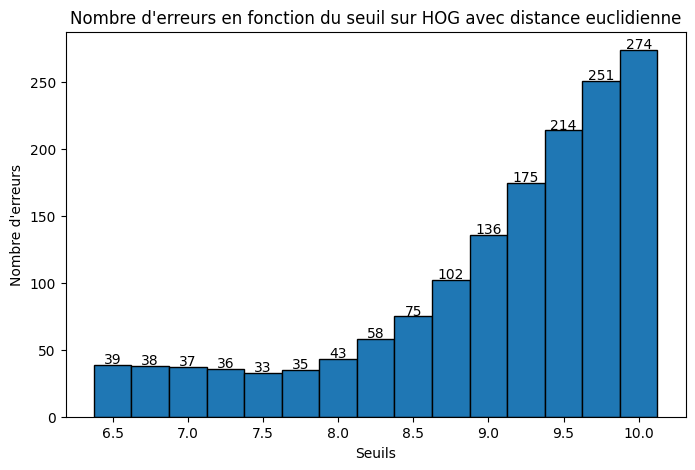

In [ ]:
import matplotlib.pyplot as plt

# Listes pour stocker les seuils et leurs erreurs associées
seuils = [6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25, 8.5, 8.75, 9, 9.25, 9.5, 9.75, 10]  # Exemple de seuils
erreurs = []  # Liste vide pour stocker les erreurs

# Calcul des erreurs pour chaque seuil
for seuil in seuils:
    erreur_tot = compare_dictionaries(hog_features_dict_rq, hog_features_dict_cmp, seuil)
    erreurs.append(erreur_tot)

# Création de l'histogramme
plt.figure(figsize=(8, 5))
plt.bar(seuils, erreurs, width=0.25, edgecolor="black")

# Ajout des labels et du titre
plt.xlabel("Seuils")
plt.ylabel("Nombre d'erreurs")
plt.title("Nombre d'erreurs en fonction du seuil sur HOG avec distance euclidienne")

# Affichage des valeurs sur les barres
for i, v in enumerate(erreurs):
    plt.text(seuils[i], v + 1, str(v), ha="center", fontsize=10)

# Affichage du graphique
plt.show()

## Comparer les dictionnairess et recherche d'images dans la base de données

Image de référence : cat_query.jpg


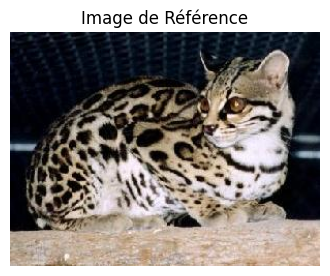

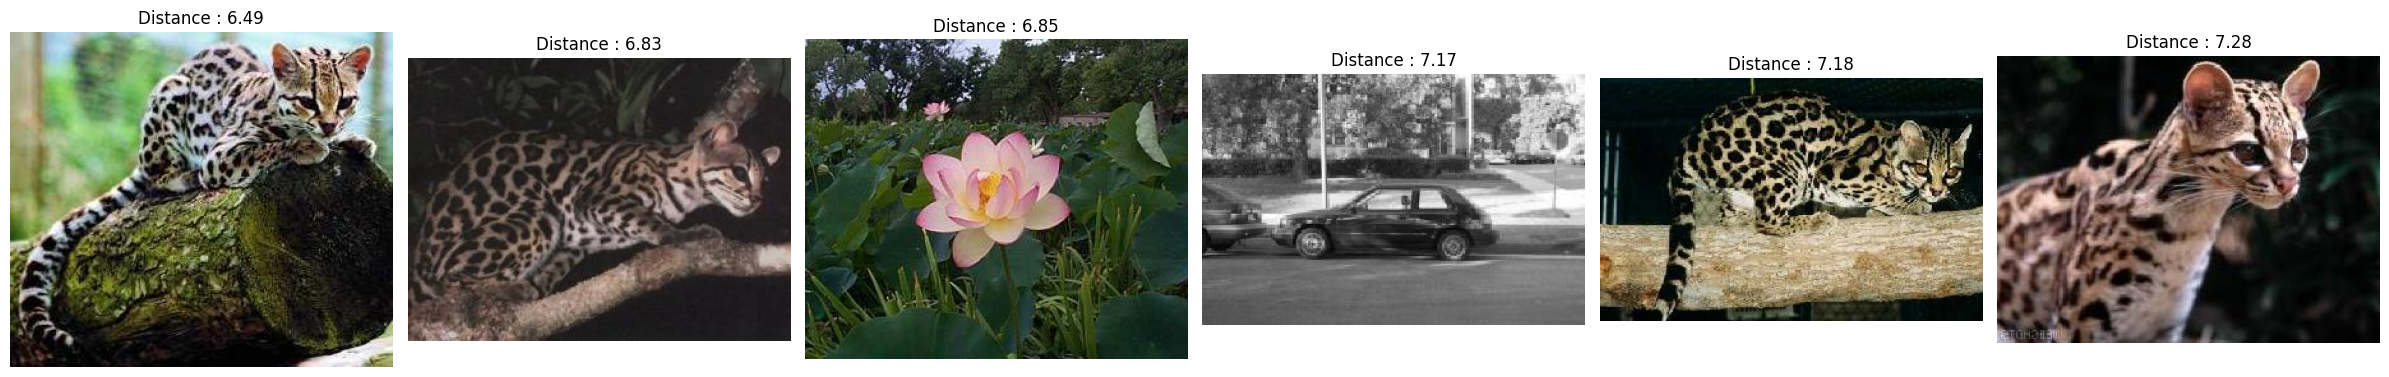

Image de référence : lotus_query.jpg


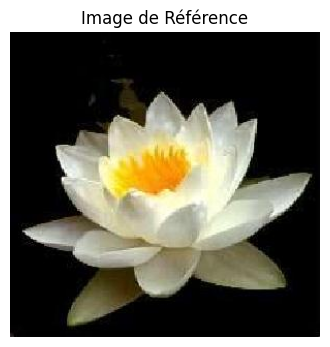

<Figure size 400x400 with 0 Axes>

Image de référence : pickles_querry.jpg


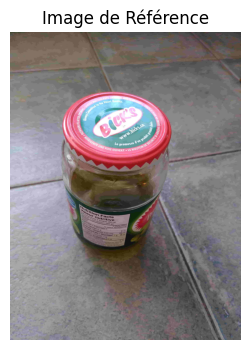

<Figure size 400x400 with 0 Axes>

Image de référence : dolphin_query.jpg


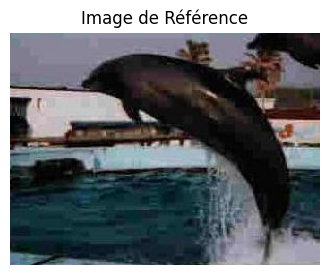

<Figure size 400x400 with 0 Axes>

Image de référence : ball_query.jpg


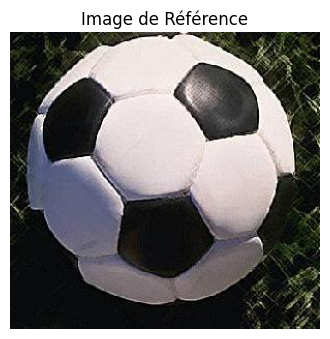

<Figure size 400x400 with 0 Axes>

Image de référence : airplane_query.jpg


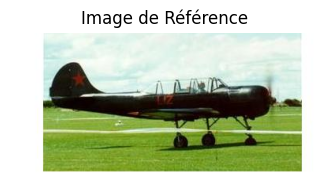

<Figure size 400x400 with 0 Axes>

Image de référence : face_query.jpg


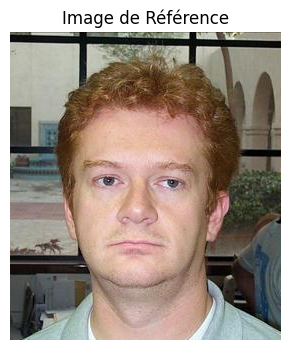

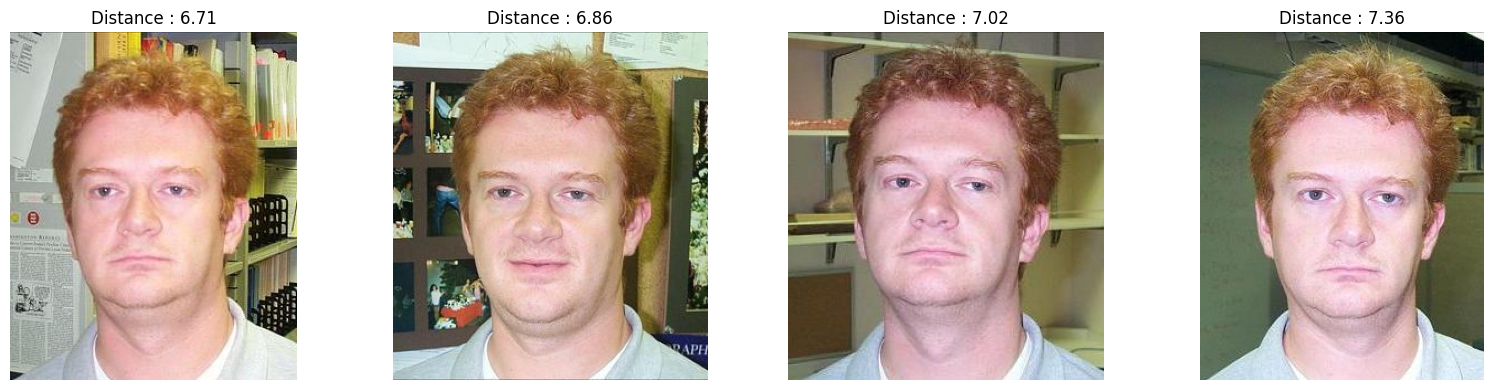

Image de référence : car_query.jpg


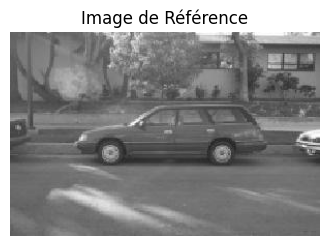

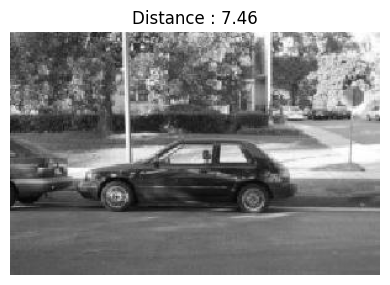

Image de référence : strawberry_query.jpg


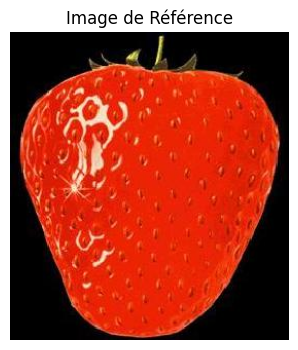

<Figure size 400x400 with 0 Axes>

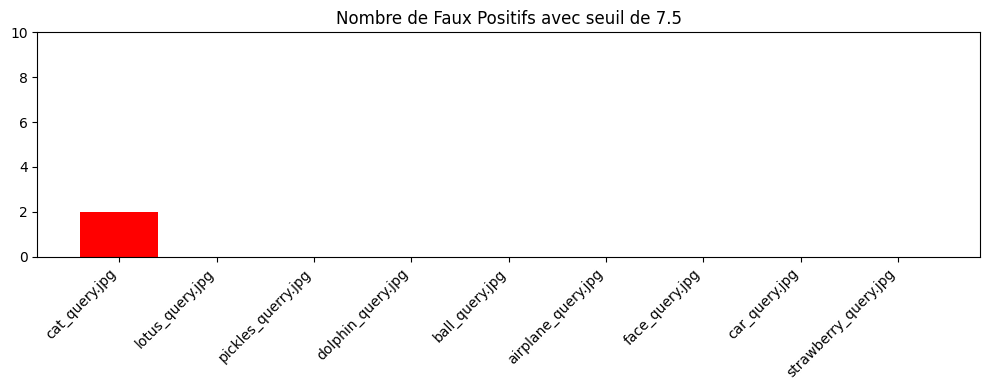

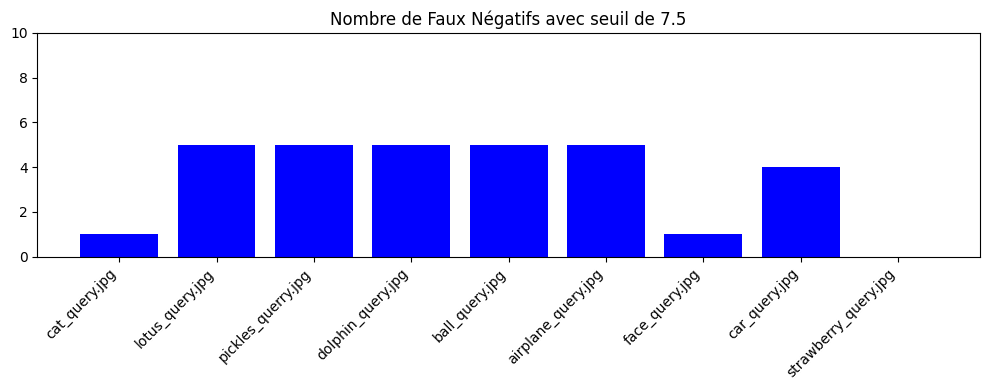

33

In [ ]:
compare_dictionaries(hog_features_dict_rq,hog_features_dict_cmp, 7.5, ranking_plot=True)